# 1. Modelo final para a previsão de pedidos em atraso

---

No [notebook](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb) passado abordamos os seguintes tópicos:

- Explicação da competição da iNeuron: objetivo, métricas, premiação (não se esqueçam, esses projetos são focados na **aprendizagem** e não em ganhar a competição);
- Quais métricas utilizar para nossos dados;
- Criar uma baseline com o modelo de regressão logística sem a nenhum tipo de pré-processamento nos dados;
- Verificar a situação que temos nos dados;
- Aplicar uma Análise Exploratória de Dados completa;

Recomendo fortemente olhar o notebook anterior pois bastante coisa que tem neste será tratada de forma direta. É isto, vamos melhorar nosso modelo anterior (baseline).

## 2. Importando as bibliotecas

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 3. Configurações adicionais

---



In [2]:
plt.style.use("seaborn-muted")
%matplotlib inline
pd.set_option('display.max_columns', None)


from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


# 4. Dados utilizados

---

Para não ficar muito sem nexo, algumas informações do banco de dados estão abaixo. 

## 4.1. Carregando o banco de dados

In [0]:
banco = pd.read_csv("/content/drive/My Drive/Training_Dataset_v2.csv", low_memory = False)

## 4.2. Dicionário das variáveis

1. sku – Random ID for the product
2. national_inv – Current inventory level for the part
3. lead_time – Transit time for product (if available)
4. in_transit_qty – Amount of product in transit from source
5. forecast_3_month – Forecast sales for the next 3 months
6. forecast_6_month – Forecast sales for the next 6 months
7. forecast_9_month – Forecast sales for the next 9 months
8. sales_1_month – Sales quantity for the prior 1 month time period
9. sales_3_month – Sales quantity for the prior 3 month time period
10. sales_6_month – Sales quantity for the prior 6 month time period
11. sales_9_month – Sales quantity for the prior 9 month time period
12. min_bank – Minimum recommend amount to stock
13. potential_issue – Source issue for part identified
14. pieces_past_due – Parts overdue from source
15. perf_6_month_avg – Source performance for prior 6 month period
16. perf_12_month_avg – Source performance for prior 12 month period
17. local_bo_qty – Amount of stock orders overdue
18. deck_risk – Part risk flag
19. oe_constraint – Part risk flag
20. ppap_risk – Part risk flag
21. stop_auto_buy – Part risk flag
22. rev_stop – Part risk flag
23. went_on_backorder – Product actually went on backorder. This is the target value.

## 4.3. Estrutura

---



In [4]:
banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

## 4.4. Sumário estatístico das variáveis

In [5]:
banco.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
national_inv,1687860.0,496.11,29615.23,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1586967.0,7.87,7.06,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1687860.0,44.05,1342.74,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1687860.0,178.12,5026.55,0.0,0.00,0.00,4.00,1427612.0
forecast_6_month,1687860.0,344.99,9795.15,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1687860.0,506.36,14378.92,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1687860.0,55.93,1928.20,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1687860.0,175.03,5192.38,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1687860.0,341.73,9613.17,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1687860.0,525.27,14838.61,0.0,0.00,4.00,47.00,3205172.0


## 5. Pré-processamento dos dados

---

Agora é a hora que ~o filho chora e a mãe não vê~, a partir da análise exploratória e de alguns insights retirados do notebook anterior, iremos fazer uma série de transformações nas variáveis.

## 5.1. Exclusão de variáveis

Somente uma, que nesse caso é a **sku**, somente um ID randômico dos produtos. Não faria sentido deixar ela no modelo.

In [6]:
banco = banco.drop("sku", axis = 1)

banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


## 5.2. Tratamento de valores nulos

Como podemos observar que: 

- Todas as variáveis possuem pelo menos um valor nulo;

-  A variável **lead_time** (transit time for product (if available)) possui 100.894 valores nulos.

In [7]:
banco.isnull().sum()

national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

Investigando a tabela abaixo, temos:

- Podemos observar que a última observação contém valores nulos para todas as variáveis. 
- Logo, devemos excluir ela;
- E a variável **lead_time**, com essa exclusão, passa a ter 100.893 valores nulos.

In [8]:
banco[banco.isnull().any(axis = 1)]

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No
2,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
4,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
6,1095.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
8,140.0,NaN,0.0,15.0,114.0,152.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687835,227.0,NaN,8.0,0.0,0.0,0.0,19.0,78.0,205.0,289.0,59.0,No,0.0,-99.0,-99.0,1.0,No,No,Yes,No,No,No
1687847,-206.0,NaN,0.0,760.0,1145.0,1453.0,114.0,853.0,1764.0,2706.0,0.0,No,0.0,-99.0,-99.0,206.0,Yes,No,No,Yes,No,No
1687850,-2.0,NaN,0.0,0.0,62.0,86.0,6.0,32.0,46.0,57.0,2.0,No,0.0,-99.0,-99.0,32.0,Yes,No,No,No,No,No
1687856,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.0,-99.0,1.0,No,No,No,Yes,No,No


In [9]:
banco = banco[: -1]

banco.tail()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687855,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,0.0,No,0.0,0.69,0.69,5.0,Yes,No,No,Yes,No,No
1687856,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No


- A variável **lead_time** nos diz respeito ao tempo de trânsito do produto (quando disponível). Fiz os seguintes testes para lidar com os valores nulos

  - Imputar a média: "Vale a pena imputar o tempo médio de trânsito ?"
  - Imputar a mediana: "Vale a pena imputar o tempo que corresponde a 50% dos pedidos em trânsito ?"
  - Imputar a moda: "Vale a pena imputar o valor mais frequente ?"
  - Substituir por um valor fora do padrão da variável.

- O método que apresentou mais eficácia nos testes foi substituir por um valor fora do padrão da variável, indicando que os valores nulos desta variável são justamente os tempos dos produtos que não estão disponíveis (são omissos). 

- Existem **N** valores para se colocar para indicar um ponto fora do padrão para o modelo, nesse caso, eu substituí os valores pelo 999.

In [0]:
banco["lead_time"] = banco["lead_time"].fillna(999)

## 5.3. Codificando as variáveis que possuem categorias "Sim" e "Não"

- Essa codificação é necessária para entrar no modelo, pois os modelos do `sklearn` pedem que as categorias das variáveis categóricas sejam números e não caracteres;

- As variáveis que foram transformadas são:

  1. potential_issue;
  2. deck_risk;
  3. oe_constraint;
  4. ppap_risk;
  5. stop_auto_buy;
  6. rev_stop;
  7. went_on_backorder.

- A transformação foi:

  - Categoria "não": 0
  - Categoria "sim": 1

In [11]:
columns_yesno = ["potential_issue", "deck_risk", "oe_constraint", "ppap_risk", "stop_auto_buy", "rev_stop", "went_on_backorder"]

banco[columns_yesno] = banco[columns_yesno].replace({"No" : 0, "Yes": 1})

banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0
2,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.10,0.13,0.0,0,0,0,1,0,0
4,8.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0


## 5.4. Criando novas features para o modelo

- Agora vem a parte legal, talvez umas das mais interessantes de toda a parte da modelagem;

- Temos que conhecer da área de negócio em que estamos envolvidos para a construção do projeto/modelo;

- Mas também, dependendo do caso, podemos criar features aleatórias para melhorar a métrica do nosso modelo (Alô, Kaggle);

- Algumas das ideias foram retiradas a partir da Análise Exploratória de Dados do notebook anterior, que está neste [link](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file);

- Ao fim do notebook, irei deixar o link para os notebooks em que testei exaustivamente features úteis e inúteis que, ao final, deram valor ao modelo.

### 5.4.1. Polinômios das variáveis

- Aqui eu testei algumas variáveis elevadas ao quadrado e ao cubo;

- Dessa transformação, a variável que mais foi útil nos testes foi o quadrado da **national_inv**;

- Isto é, o quadrado do **Nível de Estoque Atual da Peça** foi uma boa variável para o modelo;

- Note que o segundo gráfico mostra a distribuição da variável para cada uma das categorias, apesar da diferença de escalas (desculpe ao leitor, tentei de todo o jeito criar algo comparável, log, etc.), pode-se observar que há uma diferença nos locais em que as variáveis tem seus picos e, sendo assim, ela pode ser uma boa variável para separar corretamente uma categoria da outra;

- Como o banco de dados provêm de uma competição, em que pode ter dados anônimos, sintéticos, não consigo mensurar para vocês a interpretação exata dessa variável;

- Se alguém da área ler isto e puder nos explicar a relação, ficaria agradecido e faço o esforço de editar esse notebook posteriormente com a explicação.


In [12]:
banco["national_inv_poly2"] = banco["national_inv"] ** 2


banco["national_inv_poly2"].describe().apply(lambda x: "%.2f" % x)

count            1687860.00
mean           877307682.12
std         317807565195.13
min                    0.00
25%                   16.00
50%                  225.00
75%                 6400.00
max      152137522035216.00
Name: national_inv_poly2, dtype: object

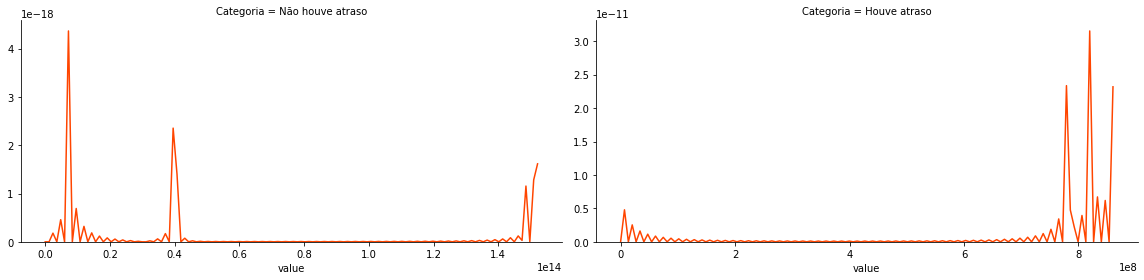

In [13]:
x = banco[banco["went_on_backorder"] == 0]["national_inv_poly2"]
y = banco[banco["went_on_backorder"] == 1]["national_inv_poly2"]

df = pd.concat([x, y], axis = 1)
df.columns = ["Não houve atraso", 'Houve atraso']
df = pd.melt(df, var_name = "Categoria")

g = sns.FacetGrid(df, col = "Categoria", col_wrap = 2, sharex = False, sharey = False, height = 4, aspect = 2)
g = g.map(sns.distplot, "value", color = "orangered", hist = False)

## 5.4.2. Categorização da variável national_inv

- Pelo que vimos anteriormente, esta variável indica o __Nível de Estoque Atual da Peça__ e ela possui valores positivos ou negativos;

- A variável criada foi justamente para saber se o nível de estoque daquele $ X_i $ produto é negativo/igual a zero ou positivo;

  - 0 se $ X_i $ <= 0;
  - 1 se $ X_i $ > 0.

- Ela será armazenada em uma variável chamada `national_inv_qual`;

- Quando relacionamos ela com a variável `went_on_backorder` (houve ou não atras), pode-se observar que a maioria das observações se concentra na categoria em que o nível de estoque do produto é positivo e em que não houve atraso para o produto.


In [14]:
banco["national_inv_qual"] = banco["national_inv"].apply(lambda x: 0 if x <= 0 else 1)

banco.groupby(["national_inv_qual", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,national_inv_qual,went_on_backorder,Quantidade
0,0,0,109470
1,0,1,4843
2,1,0,1567097
3,1,1,6450


### 5.4.3. Verificando se a variável lead_time é nula

- Essa entrou por meio dos testes;

- Como vimos anteriormente, os valores nulos nesta variável indicam que os tempos de entrega para estes produtos não estão disponíveis;

- Com base nisso, criamos uma feature justamente para indicar de outra forma: "Olha, esse valor não está disponível". Algo como um segundo indicador de observações não disponíveis para esta variável;

- Como ela é baseada na variável que fizemos uma transformação, temos

  - 0, se a variável `lead_time` não for 999;
  - 1, se a variável `lead_time` for 999;

- A maioria dos valores se concentram quando o tempo de entrega para os produtos não é nulo e quando o pedido não atrasou;

In [15]:
banco["lead_time_isnull"] = banco["lead_time"].map(lambda x: 1 if x == 999 else 0)

banco.groupby(["lead_time_isnull", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,lead_time_isnull,went_on_backorder,Quantidade
0,0,0,1575998
1,0,1,10969
2,1,0,100569
3,1,1,324


### 5.4.4. Relação `min_bank` e `national_inv`

- Por meio da correlação linear de Pearson entre essas variáveis, ver este [link](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.2.-Explorando-as-vari%C3%A1veis-quantitativas), verificamos que quanto maior o nível de estoque atual da peça, maior a quantidade mínima do produto recomendada para ficar em estoque;

- Neste [link](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.6.-Explorando-as-rela%C3%A7%C3%B5es-entre-vari%C3%A1veis-(hip%C3%B3teses)), que dá acesso ao notebook anterior, podemos ver que essa é uma das hipóteses, confirmando que há uma possível relação entre elas;

- Logo, pensei em criar uma relação entre elas, nesse caso, uma razão. E a partir dessa razão, um indicador verificando se essa relação vai ser positiva/igual a zero ou negativa

  - 0, se $ X_i $ < 0
  - 1, se $ X_i $ >= 0

- A maioria dos valores se concentra na categoria em que esta relação é positiva/igual a zero e em que não houve atraso para os produtos.


In [16]:
banco["relat_minbank_nationalinv"] = banco["min_bank"]/banco["national_inv"]
banco["relat_minbank_nationalinv"] = banco["relat_minbank_nationalinv"].apply(lambda x: 0 if x < 0 else 1)


banco.groupby(["relat_minbank_nationalinv", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,relat_minbank_nationalinv,went_on_backorder,Quantidade
0,0,0,3855
1,0,1,689
2,1,0,1672712
3,1,1,10604


### 5.4.4. Quartis das variáveis que possuem alta variação

- Como podemos observar através desta [tabela](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file) descritiva, no notebook anterior, podemos perceber que as variáveis **national_inv**, **in_transit_qty**, **min_bank**, **national_inv_poly2** possuem alta variação;

- Note também que os quartis são valores bastante atípicos, dados os seus valores máximos e mínimos;

- A partir disso, criamos novas features a partir destas variáveis justamente para verificar se o modelo consegue achar um padrão, principalmente na categoria "Houve atraso no produto";

- Podemos notar que para a feature `in_transit_qty_new` toda a distribuição ficou somente em uma categoria, logo, será retirada do banco de dados;

- As demais serão inclusas no modelo e no banco de dados por meio de variávais dummies (se você não sabe o que é uma variável dummy, não se preocupe irei deixar um artigo explicando melhor o que é ~espero me lembrar de colocar no final~);

In [17]:
colunas = ["national_inv", "in_transit_qty", "min_bank", "national_inv_poly2"]
novas_colunas = [i + "_new" for i in colunas]
banco[novas_colunas] = banco[colunas].apply(lambda x: pd.qcut(x, 4, duplicates = "drop"), axis = 0)

#--- Retirando a variável do banco

banco = banco.drop("in_transit_qty_new", axis = 1)

#--- Retirando a variável da lista, pois ela vai ser útil futuramente

novas_colunas.remove("in_transit_qty_new")

#--- Loop para verificar a relação das variáveis com a target

for coluna in banco[novas_colunas]:

  print("#--- Variável: ", coluna, "\n", 15*"---", "\n", sep = "")
    
  print(banco[coluna].value_counts(normalize = True).mul(100).round(2))
  
  print(15*"---")

#--- Variável: national_inv_new
---------------------------------------------

(-27256.001, 4.0]     26.14
(80.0, 12334404.0]    24.94
(4.0, 15.0]           24.90
(15.0, 80.0]          24.02
Name: national_inv_new, dtype: float64
---------------------------------------------
#--- Variável: min_bank_new
---------------------------------------------

(-0.001, 3.0]      75.47
(3.0, 313319.0]    24.53
Name: min_bank_new, dtype: float64
---------------------------------------------
#--- Variável: national_inv_poly2_new
---------------------------------------------

(-0.001, 16.0]                 25.94
(6400.0, 152137522035216.0]    24.99
(16.0, 225.0]                  24.97
(225.0, 6400.0]                24.09
Name: national_inv_poly2_new, dtype: float64
---------------------------------------------


### 5.4.5. É maior que o X percentil ?

- Em diversos momentos da [Análise Exploratória de Dados](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file), percebi que algumas variáveis diferem muito em quartis, se você leitor poder novamente verificar os quartis das variáveis abaixo verá do que estou falando;

- Esse problema nos quartis, me levou a seguinte pergunta: "Esse produto existe mesmo ?";

- Dado esse problema, pensei na seguinte solução: "Se o produto realmente existe, então ele tem que estar acima de X quartil";

- A partir dessa ideia, criei uma função para verificar se o $ X_i $ produtos, para as variáveis a seguir, está acima de um Z percentil;

- A partir de alguns testes, verifiquei que o percentil que melhor perfomou para os dados foi o de 85;

- A regra de decisão é, para cada variável:

  - Se $ X_i < 0 $, então 0;
  - Se $ X_i \geq 0 $, então 1.

- Assim como grande parte dos programadores, eu também não sou a pessoa mais criativa para dar nome de variáveis, espero que você me entenda, leitor.

In [18]:
ideia1 = ["national_inv", "in_transit_qty", "min_bank", "forecast_3_month", "forecast_6_month", "forecast_9_month",
          "sales_1_month", "sales_3_month", "sales_6_month", "sales_9_month"]


def isabovequant(df, quantile):

  for column in df:

    novas_colunas1 = column + '_isabove_quantile'

    selec_quantile = banco[column].quantile(q = quantile)

    banco[novas_colunas1] = banco[column].apply(lambda x: 1 if x >= selec_quantile else 0)


isabovequant(df = banco[ideia1], quantile = 0.85) 
banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,national_inv_poly2,national_inv_qual,lead_time_isnull,relat_minbank_nationalinv,national_inv_new,min_bank_new,national_inv_poly2_new,national_inv_isabove_quantile,in_transit_qty_isabove_quantile,min_bank_isabove_quantile,forecast_3_month_isabove_quantile,forecast_6_month_isabove_quantile,forecast_9_month_isabove_quantile,sales_1_month_isabove_quantile,sales_3_month_isabove_quantile,sales_6_month_isabove_quantile,sales_9_month_isabove_quantile
0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0,0.0,0,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0,4.0,1,0,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0
2,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,4.0,1,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.10,0.13,0.0,0,0,0,1,0,0,49.0,1,0,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0
4,8.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,64.0,1,1,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0


### 5.4.6. As variáveis tem $ X_i $ valores iguais a 0 ?

- Ainda por meio da [Análise Exploratória de Dados](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file), verifica-se que muitos valores destas variáveis são iguais a 0;

- As variáveis que apresentam esse padrão são forecast_3_month e sales_1_month. E a regra de decisão é

  - 0, se $ X_i \neq 0 $;
  - 1, se $ X_i = 0 $ 

In [19]:
var1 = ["forecast_3_month", "sales_1_month"]
var2 = [i + "_isesqual0" for i in var1]


banco[var2] = banco[var1].applymap(lambda x: 1 if x == 0 else 0)

banco.head()



,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,national_inv_poly2,national_inv_qual,lead_time_isnull,relat_minbank_nationalinv,national_inv_new,min_bank_new,national_inv_poly2_new,national_inv_isabove_quantile,in_transit_qty_isabove_quantile,min_bank_isabove_quantile,forecast_3_month_isabove_quantile,forecast_6_month_isabove_quantile,forecast_9_month_isabove_quantile,sales_1_month_isabove_quantile,sales_3_month_isabove_quantile,sales_6_month_isabove_quantile,sales_9_month_isabove_quantile,forecast_3_month_isesqual0,sales_1_month_isesqual0
0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0,0.0,0,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0,1,1
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0,4.0,1,0,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0,1,1
2,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,4.0,1,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0,1,1
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.10,0.13,0.0,0,0,0,1,0,0,49.0,1,0,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0,1,1
4,8.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,64.0,1,1,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0,1,1


### 5.4.7. A performance do local de venda do produto é positivo ?

- Sinceramente, façam muito bem sua Análise Exploratória de Dados, é bastante importante para retirar essas ideias;

- Percebi também que a performance nos meses 6 e 12 possuíam valores negativos;

- A partir disto, criamos um indicador para verificar se esse valor é positivo ou não, com a seguinte regra de decisão:

  - 0: se $ X_i \leq 0 $;
  - 1: se $ X_i > 0 $;

- Podemos verificar que a maioria dos valores se encaixa na categoria em que o valor da variável de performance foi positivo e em que não houve atraso no produto.

In [20]:
banco["perf_6_month_avg_isabove0"] = banco["perf_6_month_avg"].apply(lambda x: 1 if x <= 0 else 0)

banco.groupby(["perf_6_month_avg_isabove0", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,perf_6_month_avg_isabove0,went_on_backorder,Quantidade
0,0,0,1509081
1,0,1,10288
2,1,0,167486
3,1,1,1005
